# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Ознакомившись с данными, становитя понятно, что нужно где-то будет поработать с пустыми значениями, где-то придется менять тип ланных.

### Предобработка данных

*Переименовываем столбцы:*

In [2]:
data.rename(columns={'cityCenters_nearest': 'nearest_city_centres', 'parks_around3000': 'parks_around_3000', 'ponds_around3000': 'ponds_around_3000'}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

*Ищем явные дубликаты:*

In [3]:
data.duplicated().sum()

0

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера ✔️ </h2>
    
Важная проверка. Здорово, что помнишь про нее. Иногда дубликаты могут испортить весь анализ.    
   
</div>

*Ищем пропущенные значения:*

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
nearest_city_centres     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

*Причины пропусков в данных:*

ceiling_height           9195 - вероятнее всего, подрядчик просто забыл внести высоту потолков в датасет.

floors_total               86 - опять же, вероятнее всего, подрядчик забыл внести и общее количество этажей.

living_area              1903 - незаполненные данные

is_apartment            20924 - можно предположить, что это студии, и присвоить им False

kitchen_area             2278 - тут либо не внесено значение, либо это студия

balcony                 11519 - заменяем на 0 по условию

locality_name              49 - данные не внесены

airports_nearest         5542 - аэропортов по близости нет

nearest_city_centres     5519 - центр города далеко

parks_around_3000        5518 - значит парков просто нет в радиусе 3 километров

parks_nearest           15620 - парков по близости тоже нет

ponds_around_3000        5518 - водоемов в радиусе 3 км нет

ponds_nearest           14589 - водоемов поблизости нет

days_exposition          3181 - объявления не публиковались/данные утеряны

*Заполняем пропуски, удаляем незаполненные значения в графах о местности и общем количестве этажей:*

In [6]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna('False')
data['locality_name'] = data['locality_name'].fillna('Не указано')
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                     0
locality_name               0
airports_nearest         5532
nearest_city_centres     5509
parks_around_3000           0
parks_nearest           15568
ponds_around_3000           0
ponds_nearest           14552
days_exposition          3172
dtype: int64

Изменяем тип данных, где необходимо:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  object 
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

*Меняем:*
    
last_price на int

first_day_exposition на date, чтобы было удобнее работать

floors_total на int 

is_apartment на bool, поскольку есть впросы по позициям с пропусками

balcony на int

parks_around_3000/ ponds_around_3000 на int 

In [8]:
data['last_price'] = data['last_price'].astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['balcony'] = data['balcony'].astype(int)
data['parks_around_3000'] = data['parks_around_3000'].astype(int)
data['ponds_around_3000'] = data['ponds_around_3000'].astype(int)
data['floors_total'] = data['floors_total'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  int64         
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

*Ищем неявные дубликаты:*

In [9]:
def unique_places():
    return print('Количество уникальных значений locality_name:', data['locality_name'].unique().shape[0])
unique_places()

Количество уникальных значений locality_name: 365


In [10]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
unique_places()
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
unique_places()

Количество уникальных значений locality_name: 331
Количество уникальных значений locality_name: 324


*Устраним аномалии:*

In [11]:
data.describe()

total_images    last_price    total_area         rooms  ceiling_height  \
count  23613.000000  2.361300e+04  23613.000000  23613.000000    14495.000000   
mean       9.874518  6.540555e+06     60.340678      2.071147        2.771495   
std        5.681541  1.090172e+07     35.648988      1.078380        1.261445   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.799000e+06     69.800000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23613.000000  21743.000000  23613.000000  21382.000000  23613.000000   
mean      10.673824     34.462781      5.877313     10.564128      0.593063   
std        6.597173     22.037433      4.873539      5.904316      0.960307   
min        1.000000      2.000000      1.000000      1.300000      0.000000   
25%        5.000000     18.600000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.100000      0.000000   
75%       16.000000     42.300000      8.000000     12.000000      1.000000   
max       60.000000    409.700000     33.000000    112.000000      5.000000   

       airports_nearest  nearest_city_centres  parks_around_3000  \
count      18081.000000          18104.000000       23613.000000   
mean       28788.008185          14185.084015           0.468810   
std        12626.209956           8614.132292           0.748489   
min            0.000000            181.000000           0.000000   
25%        18575.000000           9233.750000           0.000000   
50%        26726.000000          13093.000000           0.000000   
75%        37242.000000          16287.000000           1.000000   
max        84869.000000          65968.000000           3.000000   

       parks_nearest  ponds_around_3000  ponds_nearest  days_exposition  
count    8045.000000       23613.000000    9061.000000     20441.000000  
mean      490.554630           0.590480     518.209469       180.884839  
std       341.336698           0.884436     277.887489       219.685543  
min         1.000000           0.000000      13.000000         1.000000  
25%       288.000000           0.000000     294.000000        45.000000  
50%       455.000000           0.000000     503.000000        95.000000  
75%       612.000000           1.000000     730.000000       232.000000  
max      3190.000000           3.000000    1344.000000      1580.000000

In [12]:
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100.000:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)
data.drop(index=data.query('last_price < 1e+05').index,inplace=True)

Квартир стоимостью 0: 0
Квартир стоимостью меньше 100.000: 1
Квартир стоимостью больше 100.000.000: 37
Квартир стоимостью больше 100.000.000: 37


Тут убираем квартиры стоимостью больше 100 млн, не совсем реальные цифры, как мне кажется, похоже на аномальное значение

In [13]:
print('Квартир площадью менее 10 кв.м.:',data.query('total_area < 10')['total_area'].count()) 
print('Квартир площадью более 500 кв.м.:',data.query('total_area > 500')['total_area'].count())
data.drop(index=data.query('total_area > 500').index,inplace=True)

Квартир площадью менее 10 кв.м.: 0
Квартир площадью более 500 кв.м.: 3


Тут убираем квартиры с площадью больше 500 кв м; по площади занимаят явно больше чем этаж многоквартирного дома => выброс

In [14]:
print('Нет комнат:',data.query('rooms == 0')['rooms'].count())
print('Нет комнат + студии:',data.query('rooms == 0 and studio')['rooms'].count()) 
print('Нет комнат + апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 
print('Нет комнат + свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())
print('Нет комнат + не апартаменты + не свободная планировка:', data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())
data.drop(index=data.query('rooms > 7').index,inplace=True)

Нет комнат: 194
Нет комнат + студии: 135
Нет комнат + апартаменты: 188
Нет комнат + свободная планировка: 59
Нет комнат + не апартаменты + не свободная планировка: 0


Тут убираем, где больше 7 комнат, не совсем похоже на квартиру.

In [15]:
print('Площадь кухни меньше 2 кв.м.: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни 5 кв.м.: ',data.query('kitchen_area == 5')['living_area'].count())
print('Площадь кухни больше 50 кв.м.: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())
data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

Площадь кухни меньше 2 кв.м.:  1
Площадь кухни 5 кв.м.:  352
Площадь кухни больше 50 кв.м.:  37
Площадь кухни больше общей:  0


Избавляемся от слишком маленьких и слишком больших кухонь

In [16]:
print('Жилая площадь меньше 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200: ',data.query('living_area > 200')['living_area'].count())
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

Жилая площадь меньше 10 кв.м.:  25
Жилая площадь больше общей:  0
Жилая площадь больше 200:  10


Тут разбираемся с жилой площадью, если она меньше 10 то это как-то совсем печально, по нормам(вроде бы) минимум 8, скорее всего, какая-то аномалия, как и площадь свыше 200 м кв

***Вывод по предобработке данных:***
1) Изучены данные

2) Внесены изменения в названия столбцов в стиле snake 

3) Дубликаты не найдены

4) пропуски найдены, попыталась установить их природу

5) Заполнила пропуски там, где было возможно

6) Постаралась разобраться с аномалиями, исключить их

### Посчитайте и добавьте в таблицу новые столбцы

Цена за метр квадратный:

In [18]:
data['price_per_square_meter'] = data['last_price'] / data['total_area']
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70            16         51.0      8        False  ...   
1             NaN            11         18.6      1        False  ...   
2             NaN             5         34.3      4        False  ...   
3             NaN            14          NaN      9        False  ...   
4            3.03            14         32.0     13        False  ...   

   balcony    locality_name  airports_nearest  nearest_city_centres  \
0        0  Санкт-Петербург           18863.0               16028.0   
1        2   поселок Шушары           12817.0               18603.0   
2        0  Санкт-Петербург           21741.0               13933.0   
3        0  Санкт-Петербург           28098.0                6800.0   
4        0  Санкт-Петербург           31856.0                8098.0   

  parks_around_3000  parks_nearest  ponds_around_3000  ponds_nearest  \
0                 1          482.0                  2          755.0   
1                 0            NaN                  0            NaN   
2                 1           90.0                  2          574.0   
3                 2           84.0                  3          234.0   
4                 2          112.0                  1           48.0   

   days_exposition  price_per_square_meter  
0              NaN           120370.370370  
1             81.0            82920.792079  
2            558.0            92785.714286  
3            424.0           408176.100629  
4            121.0           100000.000000  

[5 rows x 23 columns]

Дата публикации:

In [19]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70            16         51.0      8        False  ...   
1             NaN            11         18.6      1        False  ...   
2             NaN             5         34.3      4        False  ...   
3             NaN            14          NaN      9        False  ...   
4            3.03            14         32.0     13        False  ...   

   nearest_city_centres  parks_around_3000  parks_nearest  ponds_around_3000  \
0               16028.0                  1          482.0                  2   
1               18603.0                  0            NaN                  0   
2               13933.0                  1           90.0                  2   
3                6800.0                  2           84.0                  3   
4                8098.0                  2          112.0                  1   

  ponds_nearest  days_exposition  price_per_square_meter  weekday  month  year  
0         755.0              NaN           120370.370370        3      3  2019  
1           NaN             81.0            82920.792079        1     12  2018  
2         574.0            558.0            92785.714286        3      8  2015  
3         234.0            424.0           408176.100629        4      7  2015  
4          48.0            121.0           100000.000000        1      6  2018  

[5 rows x 26 columns]

Разделяем квартиры по категориям:

In [20]:
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_group, axis=1)
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70            16         51.0      8        False  ...   
1             NaN            11         18.6      1        False  ...   
2             NaN             5         34.3      4        False  ...   
3             NaN            14          NaN      9        False  ...   
4            3.03            14         32.0     13        False  ...   

   parks_around_3000  parks_nearest  ponds_around_3000  ponds_nearest  \
0                  1          482.0                  2          755.0   
1                  0            NaN                  0            NaN   
2                  1           90.0                  2          574.0   
3                  2           84.0                  3          234.0   
4                  2          112.0                  1           48.0   

  days_exposition  price_per_square_meter  weekday  month  year  floor_type  
0             NaN           120370.370370        3      3  2019      другой  
1            81.0            82920.792079        1     12  2018      первый  
2           558.0            92785.714286        3      8  2015      другой  
3           424.0           408176.100629        4      7  2015      другой  
4           121.0           100000.000000        1      6  2018      другой  

[5 rows x 27 columns]

Расстояние в км до города:

In [22]:
data['city_centres'] = (data['nearest_city_centres'] / 1000).round()
display(data)

total_images  last_price  total_area first_day_exposition  rooms  \
0                20    13000000      108.00           2019-03-07      3   
1                 7     3350000       40.40           2018-12-04      1   
2                10     5196000       56.00           2015-08-20      2   
3                 0    64900000      159.00           2015-07-24      3   
4                 2    10000000      100.00           2018-06-19      2   
...             ...         ...         ...                  ...    ...   
23694             9     9700000      133.81           2017-03-21      3   
23695            14     3100000       59.00           2018-01-15      3   
23696            18     2500000       56.70           2018-02-11      2   
23697            13    11475000       76.75           2017-03-28      2   
23698             4     1350000       32.30           2017-07-21      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0                2.70            16         51.0      8        False  ...   
1                 NaN            11         18.6      1        False  ...   
2                 NaN             5         34.3      4        False  ...   
3                 NaN            14          NaN      9        False  ...   
4                3.03            14         32.0     13        False  ...   
...               ...           ...          ...    ...          ...  ...   
23694            3.70             5         73.3      3        False  ...   
23695             NaN             5         38.0      4        False  ...   
23696             NaN             3         29.7      1        False  ...   
23697            3.00            17          NaN     12        False  ...   
23698            2.50             5         12.3      1        False  ...   

       parks_nearest  ponds_around_3000  ponds_nearest  days_exposition  \
0              482.0                  2          755.0              NaN   
1                NaN                  0            NaN             81.0   
2               90.0                  2          574.0            558.0   
3               84.0                  3          234.0            424.0   
4              112.0                  1           48.0            121.0   
...              ...                ...            ...              ...   
23694          796.0                  3          381.0              NaN   
23695            NaN                  0            NaN             45.0   
23696            NaN                  0            NaN              NaN   
23697          173.0                  3          196.0            602.0   
23698            NaN                  0            NaN              NaN   

      price_per_square_meter  weekday  month  year  floor_type  city_centres  
0              120370.370370        3      3  2019      другой          16.0  
1               82920.792079        1     12  2018      первый          19.0  
2               92785.714286        3      8  2015      другой          14.0  
3              408176.100629        4      7  2015      другой           7.0  
4              100000.000000        1      6  2018      другой           8.0  
...                      ...      ...    ...   ...         ...           ...  
23694           72490.845228        1      3  2017      другой           4.0  
23695           52542.372881        0      1  2018      другой           NaN  
23696           44091.710758        6      2  2018      первый           NaN  
23697          149511.400651        1      3  2017      другой          10.0  
23698           41795.665635        4      7  2017      первый           NaN  

[23471 rows x 28 columns]

***Вывод по данному разделу:***
 посчитано и добавлено в таблицу: цена одного квадратного метра
 
 посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
 
 посчитано и добавлено в таблицу: месяц публикации объявления
 
 посчитано и добавлено в таблицу: год публикации объявления
 
 посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
 
 посчитано и добавлено в таблицу: расстояние в км до центра города

### Проведите исследовательский анализ данных

*Ознакомимся с данными:*

In [23]:
data.describe()

total_images    last_price    total_area         rooms  ceiling_height  \
count  23471.000000  2.347100e+04  23471.000000  23471.000000    14395.000000   
mean       9.859784  6.139471e+06     59.267389      2.052831        2.767684   
std        5.676244  5.984396e+06     30.686121      1.022635        1.264002   
min        0.000000  4.300000e+05     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.510000   
50%        9.000000  4.600000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.700000e+06     69.000000      3.000000        2.800000   
max       50.000000  9.900000e+07    494.100000      7.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23471.000000  21608.000000  23471.000000  21252.000000  23471.000000   
mean      10.689830     33.873635      5.878744     10.388157      0.593882   
std        6.600306     19.313964      4.875436      5.145945      0.960420   
min        1.000000     10.000000      1.000000      2.000000      0.000000   
25%        5.000000     18.600000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.005000      0.000000   
75%       16.000000     42.100000      8.000000     12.000000      1.000000   
max       60.000000    200.000000     33.000000     50.000000      5.000000   

       ...  parks_around_3000  parks_nearest  ponds_around_3000  \
count  ...       23471.000000    7944.000000       23471.000000   
mean   ...           0.464062     491.057276           0.586383   
std    ...           0.743998     341.184091           0.880567   
min    ...           0.000000       1.000000           0.000000   
25%    ...           0.000000     288.000000           0.000000   
50%    ...           0.000000     455.000000           0.000000   
75%    ...           1.000000     612.000000           1.000000   
max    ...           3.000000    3190.000000           3.000000   

       ponds_nearest  days_exposition  price_per_square_meter       weekday  \
count    8973.000000     20322.000000            23471.000000  23471.000000   
mean      519.229689       180.286389            98286.609455      2.568489   
std       277.760426       219.127615            42548.332574      1.788231   
min        13.000000         1.000000             7962.962963      0.000000   
25%       295.000000        45.000000            76495.614035      1.000000   
50%       503.000000        95.000000            94843.750000      3.000000   
75%       732.000000       231.000000           113883.946224      4.000000   
max      1344.000000      1580.000000           848484.848485      6.000000   

              month          year  city_centres  
count  23471.000000  23471.000000  17965.000000  
mean       6.404201   2017.369733     14.229223  
std        3.492449      1.038653      8.615652  
min        1.000000   2014.000000      0.000000  
25%        3.000000   2017.000000      9.000000  
50%        6.000000   2017.000000     13.000000  
75%       10.000000   2018.000000     16.000000  
max       12.000000   2019.000000     66.000000  

[8 rows x 22 columns]

*Гистограмма по общей площади:*

In [24]:
data.hist('total_area', bins=100)
plt.title('Гистограмма по общей площади')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')

Text(0, 0.5, 'Количество квартир')

*Гистограмма по жилищной площади:*

Text(0, 0.5, 'Количество квартир')

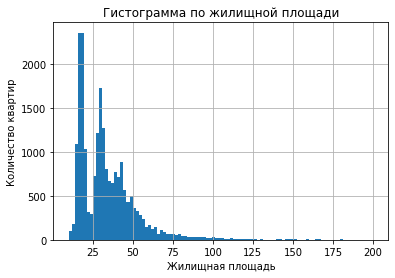

In [25]:
data.hist('living_area', bins=100)
plt.title('Гистограмма по жилищной площади')
plt.xlabel('Жилищная площадь')
plt.ylabel('Количество квартир')

*Гистограмма по площади кухни+гистограмма с ранжированием по наиболее часто встречающемуся диапазону(0-20 м):*

Text(0, 0.5, 'Количество квартир')

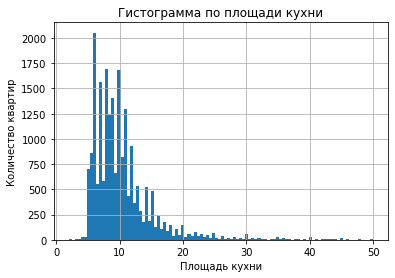

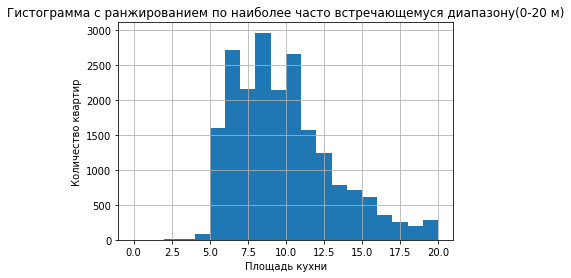

In [26]:
data.hist('kitchen_area', bins=100)
plt.title('Гистограмма по площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
data.hist('kitchen_area', bins=20, range=(0,20))
plt.title('Гистограмма с ранжированием по наиболее часто встречающемуся диапазону(0-20 м)')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')

*Гистограмма по цене+гистограмма по наиболее типичному диапазону:*

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

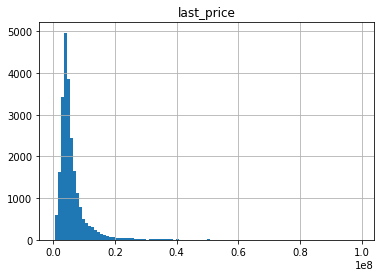

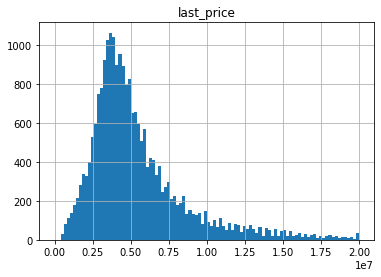

In [27]:
data.hist('last_price', bins=100)
data.hist('last_price', bins=100, range=(0,2e+07))

*Гистограмма по количеству комнат:*

Text(0, 0.5, 'Количество квартир')

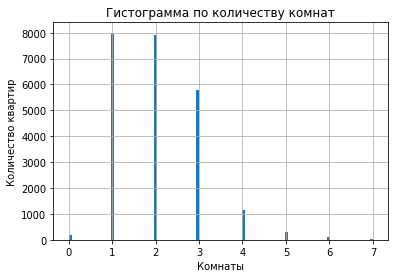

In [28]:
data.hist('rooms', bins=100)
plt.title('Гистограмма по количеству комнат')
plt.xlabel('Комнаты')
plt.ylabel('Количество квартир')

*Гистограмма по высоте потолков:*

In [29]:
data.hist('ceiling_height', bins=30, range=(1, 6))
plt.title('Гистограмма по высоте потолков')
plt.xlabel('Высота в метрах')
plt.ylabel('Количество квартир')

Text(0, 0.5, 'Количество квартир')

*Гистограмма по этажу продаваемой недвижимости:*

Text(0, 0.5, 'Количество квартир')

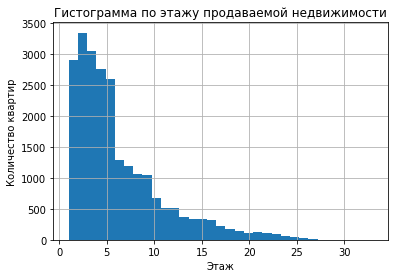

In [30]:
data.hist('floor', bins=data['floor'].max())
plt.title('Гистограмма по этажу продаваемой недвижимости')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')

*Гистограмма по типу этажа:*

Text(0, 0.5, 'Количество квартир')

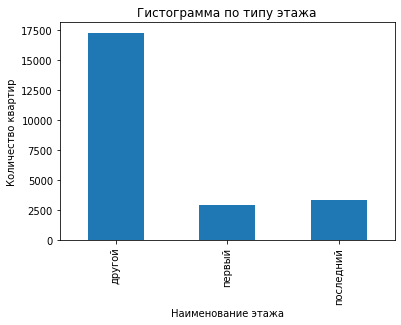

In [31]:
data.groupby(by='floor_type')['floor_type'].count().plot(kind='bar', ylabel = 'count')
plt.title('Гистограмма по типу этажа')
plt.xlabel('Наименование этажа')
plt.ylabel('Количество квартир')

*Гистограмма по общему количеству этажей:*

Text(0, 0.5, 'Количество квартир')

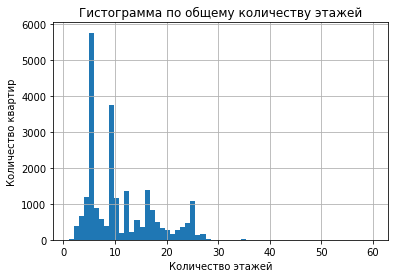

In [32]:
data.hist('floors_total', bins=data['floors_total'].max())
plt.title('Гистограмма по общему количеству этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Количество квартир')

*Гистограмма по удаленности от центра:*

In [33]:
data.hist('nearest_city_centres', bins=100)
plt.title('Гистограмма по удаленности от центра')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество квартир')

Text(0, 0.5, 'Количество квартир')

*Гистограмма по близости аэрпорта:*

Text(0, 0.5, 'Количество квартир')

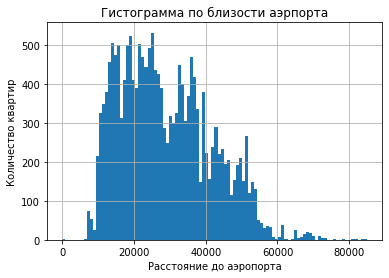

In [34]:
data.hist('airports_nearest', bins=100)
plt.title('Гистограмма по близости аэрпорта')
plt.xlabel('Расстояние до аэропорта')
plt.ylabel('Количество квартир')

*Гистограмма по близости парков:*

Text(0, 0.5, 'Количество квартир')

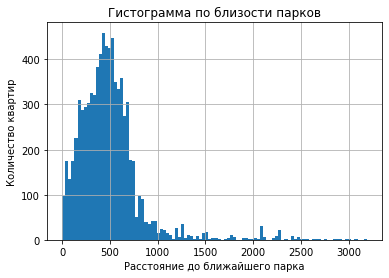

In [35]:
data.hist('parks_nearest', bins=100)
plt.title('Гистограмма по близости парков')
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество квартир')

*Гистограмма по дню публикации:*

Text(0, 0.5, 'Количество объявлений')

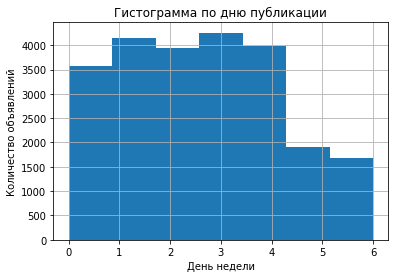

In [36]:
data.hist('weekday', bins=7)
plt.title('Гистограмма по дню публикации')
plt.xlabel('День недели')
plt.ylabel('Количество объявлений')

*Гистограмма по месяцу публикации:*

Text(0, 0.5, 'Количество объявлений')

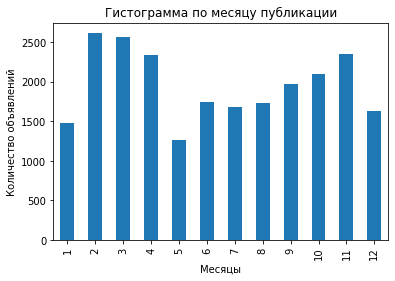

In [37]:
#data.hist('month', bins=12)
data.groupby(by='month')['month'].count().plot(kind='bar', ylabel = 'count')
plt.title('Гистограмма по месяцу публикации')
plt.xlabel('Месяцы')
plt.ylabel('Количество объявлений')

*Вывод:*

1)среднестатистическая площадь квартир на продаже чуть меньше 50 м кв

2)график жилой части имеет два пика: +- 13 кв м и +- 30 кв м; первый скачок соответствует, вероятнее всего, студиям и совсем небольшим квартирам, а второй уже полноразмерным квартирам.

3)в среднем кухни занимают не более 8-10 кв м

4)наиболее частовстречающиеся квартиры - однокомнатные и двухкомнатные

5)наиболее часто продаются квартиры с первого по пятый этаж

6)больше всего квартир продается не в высотных домах(до 10 этажей)

7)достаточно мало квартир продается в непосредственной близости к центру, больше всего +- в 15 км от центра

8)в непосредственной близости к аэропорту квартир нет, этообусловлено техническими требованиями по регуляции авиасообщения

9)многие квартиры имеют парк в непосредственной близости к дому

10)чаще всего объявления размещают в период рабочей недели, поскольку редко этим занимаются именно сами владельцы, зачастую это делают агенства с фиксированными рабочими днями пн/пт

11)чаще всего публикуют объявления о продаже в феврале-марте, реже всего - в январе и мае


*Изучаем столбец days_exposition*

count    20322.000000
mean       180.286389
std        219.127615
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

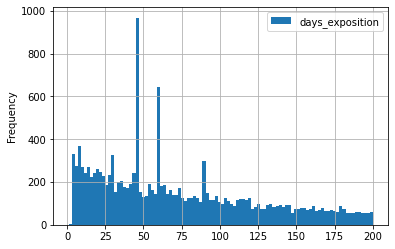

In [38]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))
data[data['days_exposition']!=0]['days_exposition'].describe()

*Вывод:*
Исходя из построенных гистограмм, понятно, что наиболее частный и можно сказать оптимальный срок продажи это +-45-95 дней, то есть в среднем 2-3 месяца. Наиболее быстрыми можно считать продажи, если объявление провисело не больше пары дней, тогда как долгими считаются те, что оставались в опубликованных более 230 дней.

*Факторы, влияющие на стоимость квартир:*

0.7580326276760689

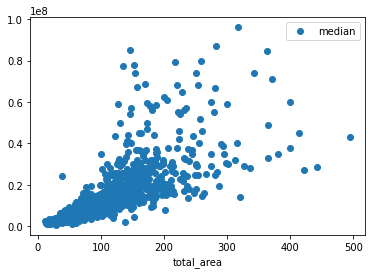

In [39]:
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)
data['total_area'].corr(data['last_price'])

Корелляция есть и она явно самая большая, соответственно, больше всего на стоимость квартир влияет площадь!

In [40]:
#pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
#pivot_table_rooms.columns = ['mean', 'count', 'median']
#pivot_table_rooms.query('count > 50').plot(y = 'median')

#pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)

data.pivot_table(index='rooms', values='last_price')

last_price
rooms              
0      3.353238e+06
1      3.829817e+06
2      5.537083e+06
3      7.968750e+06
4      1.216318e+07
5      1.817428e+07
6      2.352087e+07
7      2.511609e+07

Тут достаточно интересный результат исследования, из которого получается, что самые дорогие это трехкомнатные квартиры, что не особо удивляет, однако 4/5/6/7-комнатные квартиры стоят меньше студий; можно предположить, что это обусловлено а)нестандартностью жилья, б) затраты на его содержание явно перекроют такую достаточно небольшую себестоимость.

0.6694605452851541

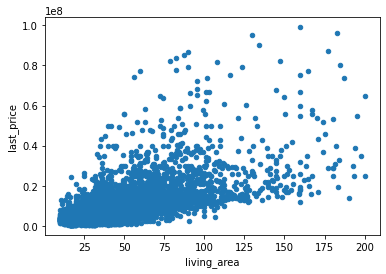

In [66]:
data.pivot_table(index='living_area', values='last_price')
data.plot(kind = 'scatter', y = 'last_price', x = 'living_area', alpha = 1)
data['living_area'].corr(data['last_price'])

*Вывод:* тут чем больше площадь, тем больше цена, что обусловлено увеличением этой самой площади. Графиком это подтверждается, буквально пару значений в разных "метражах" квартир выбиваются, но это может быть обусловлено различными факторами, начиная от цены не по рынку, заканчивая какими-нибудь элитными ЖК.

0.5599810056890766

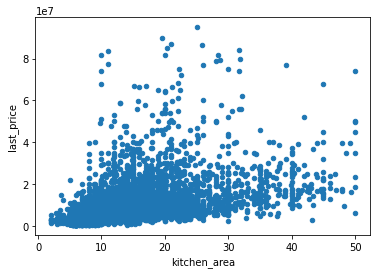

In [68]:
data.plot(kind = 'scatter', y = 'last_price', x = 'kitchen_area', alpha = 1)
data['kitchen_area'].corr(data['last_price'])

*Вывод:* на самом деле, зависимость есть. Если визуально проводить линию, то можно заметить как с возрастанием площади кухни, увеличивается и цена. Да, можно сказать, что кухни от 5 до 15 кв метров имеют несильно отличающиеся стоимости, но если кухни уже 20-50 кв метров, то, естественно, квартира стоит больше.

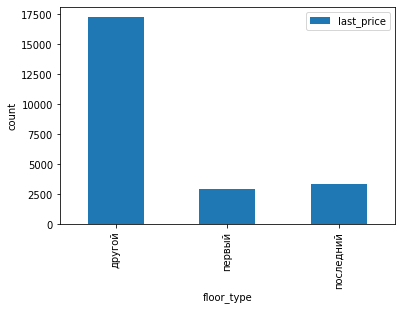

In [43]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='count').plot(kind='bar', ylabel = 'count')
plt.show()

In [44]:
data.pivot_table(index='floor_type', values='last_price')

last_price
floor_type              
другой      6.382021e+06
первый      4.690582e+06
последний   6.145225e+06

*Вывод:* первые и последние этажи дешевле, чем все остальные, хотя последние не сильно отличаются в цене от всех, кроме первого. Это может быть обусловлено тем, что люди не хотят жить рядом с какими-то магазинчиками, которые располагают на первых этажах зданий, возможно, хотят тишины, которой трудно добиться на первом этаже ввиду близости дорог и близости мест общественной активности.

-0.3048888391900878

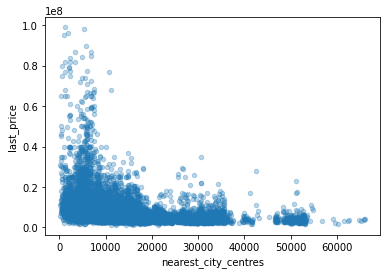

In [45]:
data.plot(kind = 'scatter', y = 'last_price', x = 'nearest_city_centres', alpha = 0.3)

data['nearest_city_centres'].corr(data['last_price'])

*Вывод:* интересно, но тут корреляция отрицательная, что говорит о том, что близость к центру практически не влияет на стоимость квартиры.

mean  count   median
weekday                              
1        6.013860e+06   4142  4700000
2        6.141094e+06   3932  4700000
0        6.148034e+06   3579  4640000
3        6.420085e+06   4257  4600000
4        6.115916e+06   3976  4550000
5        5.960863e+06   1906  4500000
6        5.974348e+06   1679  4500000

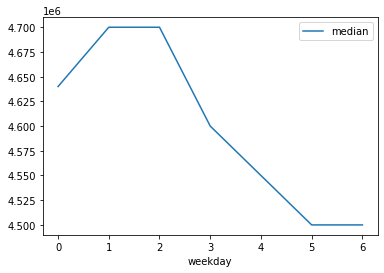

In [46]:
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

*Вывод:* день размещения так же влияет крайне мало, +-20000 тысяч в зависимости от дня

mean    count  median
month                               
2      6.134798e+06  4650000    2616
3      5.982743e+06  4645000    2566
11     6.230940e+06  4700000    2355
4      6.037263e+06  4780000    2343
10     5.903769e+06  4550000    2097
9      6.311093e+06  4700000    1968
6      6.092639e+06  4400000    1744
8      6.088109e+06  4550000    1732
7      6.228180e+06  4600000    1677
12     6.418548e+06  4690000    1632
1      6.203511e+06  4600000    1481
5      6.192281e+06  4500000    1260

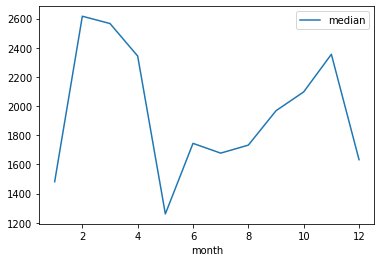

In [47]:
pivot_table_month = data.pivot_table(index='month', values='last_price', aggfunc=['mean', 'median', 'count'])
pivot_table_month.columns = ['mean', 'count', 'median']
pivot_table_month.plot(y = 'median')

pivot_table_month.sort_values('median', ascending = False)

*Вывод:* тут размах чуть больше, +-30000 рублей, но все же не играет определяющей роли.

mean  count   median
year                              
2014  1.169807e+07    136  7640000
2015  7.572732e+06   1168  5300000
2019  6.478389e+06   2857  5047000
2018  5.776914e+06   8456  4550000
2016  6.339106e+06   2748  4500000
2017  6.030771e+06   8106  4500000

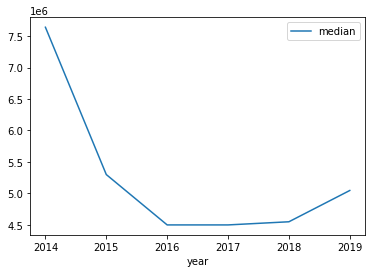

In [48]:
pivot_table_year_exposition = data.pivot_table(index = 'year', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

*Вывод:* Самые дорогие квартиры были выставлены в 2014 году, после этого цена отличалась не более чем на 50000 рублей.

In [49]:
display('Коэффициент корреляции между площадью и стоимостью:', data['total_area'].corr(data['last_price']))
display('Коэффициент корреляции между числом комнат и стоимостью:', data['rooms'].corr(data['last_price']))
display('Коэффициент корреляции между расстоянием до центра и стоимостью:', data['nearest_city_centres'].corr(data['last_price']))

'Коэффициент корреляции между площадью и стоимостью:'

0.7580326276760689

'Коэффициент корреляции между числом комнат и стоимостью:'

0.460518300197096

'Коэффициент корреляции между расстоянием до центра и стоимостью:'

-0.3048888391900878

*Вывод:*

Исходя из корреляции понимаем, что:

**Цена зависит от:**

1)общей площади(~0,76), что и неудивительно, поскольку ценообразование отталкивается от квадратуры, соответственно, чем она больше, тем выше цена.

2)количества комнат(~0.46)

3)от типа этажа(первые и последние этажы дешевле, чем все остальные)

**Цена практически на зависит от:**

1)даты размещение(в конкретный день или месяц); да, есть не особо прибыльные месяцы по типу января, но разница составляет до 50000 рублей, что в контексте миллионов явно не играет особой роли.

2)года размещения (тут и без корелляции видно, что самые дорогие квартиры были выставлены в 2014 году, в последующие годы цена варировалась в районе +-50 тысяч рублей)

3)расстояние до центра(~-0.30), то есть корелляция отрицательная, соответственно, зависимости, можно сказать нет.


*Ищем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.*

In [50]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table

count           mean
locality_name                          
Санкт-Петербург    15517  113327.917582
поселок Мурино       551   85601.120803
поселок Шушары       438   78577.014984
Всеволожск           398   68654.473986
Пушкин               365  102900.024689
Колпино              337   75333.295801
поселок Парголово    327   90175.913458
Гатчина              307   68746.146763
деревня Кудрово      299   92473.547576
Выборг               237   58141.909153

*Находим максимальную цену:*

In [51]:
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]

count           mean
locality_name                        
Санкт-Петербург  15517  113327.917582

*Находим минимальную цену:*

In [52]:
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

count          mean
locality_name                     
Выборг           237  58141.909153

*Теперь вычисляем стоимость каждого километра:*

price_per_square_meter
city_centres                        
0.0                    217865.966797
1.0                    155035.212530
2.0                    148736.461929
3.0                    120779.164963
4.0                    128011.223798
5.0                    136959.415584
6.0                    144388.501451
7.0                    153113.732755
8.0                    124602.112700
9.0                    113350.979313
10.0                   112785.843109
11.0                   108394.957199
12.0                   107467.809744
13.0                   108021.631657
14.0                   104117.383225
15.0                   104214.149153
16.0                   100478.789778
17.0                    96937.305063
18.0                    96362.263941
19.0                    98718.733678
20.0                   103045.181922
21.0                    94469.584582
22.0                    91330.425050
23.0                    91828.517765
24.0                    85736.904595
25.0                    91531.371618
26.0                    87798.872892
27.0                   132115.709459
28.0                    81161.915320
29.0                    72953.365445

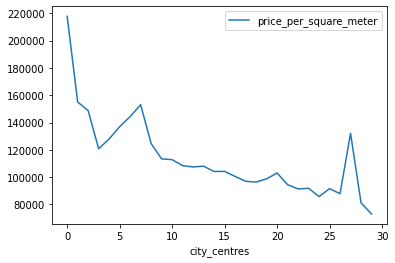

In [53]:
data['city_centres'] = data['city_centres'].fillna(999999)
pivot_table_price_for_km = data.query('locality_name == "Санкт-Петербург" and city_centres !=999999').pivot_table(index = 'city_centres', values = 'price_per_square_meter', aggfunc = 'mean')
pivot_table_price_for_km.plot()
pivot_table_price_for_km

*Вывод:*
Очевдно, что недвижимость ближе к центру будет наиболее дорогой, что и происходит(1км самый дорогой); потом идет недвижимость чуть дешевле со 2-7 км; далее цена снижается с 8 по 27, однако на 27 км недвижимость стоит практически как в центре, из этого следует либо это какой-то элитный загородный район, либо какая-то манипуляция данными.

*Для общего вывода*

In [54]:
display(data['total_area'].describe())
display(data['total_area'].median())

count    23471.000000
mean        59.267389
std         30.686121
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        494.100000
Name: total_area, dtype: float64

52.0

In [55]:
display(data['last_price'].describe())
display(data['last_price'].median())

count    2.347100e+04
mean     6.139471e+06
std      5.984396e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.700000e+06
max      9.900000e+07
Name: last_price, dtype: float64

4600000.0

### Общий вывод

1)Цена зависит в большинстве своем от общей площади(0,76), что и неудивительно, количества комнат(0.46), согласно корреляции, от типа этажа(первые и последние этажы дешевле, чем все остальные) и практически не зависят от даты размещение(в конкретный день или месяц); да, есть не особо прибыльные месяцы по типу января, но разница составляет до 50000 рублей, что в контексте миллионов явно не играет особой роли, года размещения (тут и без корелляции видно, что самые дорогие квартиры были выставлены в 2014 году, в последующие годы цена варировалась в районе +-50 тысяч рублей), расстояние до центра(~-0.30), то есть корелляция отрицательная, соответственно, зависимости, можно сказать, нет; также есть прямая зависимость от общей площади и площади кухни(чем больше, тем дороже).

2)Быстрыми можно считать продажи от 45 до 95 дней, а наиболее длительными те, что составляют более 230 дней

3)Наиболее дорогой недвижимостью после Петербурга обладает поселок Мурино(85601 рублей за квадратный метр), а не город из области, что достаточно примечательно

4)Обнаружен так же какой-то, по всей видимости, элитный населенный пункт в 27 км от Петербурга, где стоимость метра квадратного чуть ниже, чем в самом центре города

5)Среднее значение цены за квадратный метр в Петербурге составляет 113327 рублей

6)Медианой цены за квартиру является сумма в 4.600.000 рублей, тогда как медианное значение площади составляет 52 метра квадратных

7)Чаще всего продают стандартные одно/двухкомнатные квартиры в невысотных домах на удалении от центра 10-15 км

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод